# Регрессия Decision Tree

Выполните подготовку данных для решения задачи регрессии. Проведите регрессию методом решающих деревьев. Качество оценить минимум по 3 критериям качества для регрессии: MAE, MSE, RMSE, MAPE, RMSLE, R^2 и др.

**Описание набора данных:**

- Age: Возраст застрахованного лица (Numerical)
- Gender: Пол застрахованного лица (Categorical: Male, Female)
- Annual Income: Годовой доход застрахованного лица (Numerical, skewed)
- Marital Status: Семейное положение застрахованного лица (Categorical: Single, Married, Divorced)
- Number of Dependents: Количество иждивенцев (Numerical, with missing values)
- Education Level: Наивысший достигнутый уровень образования (Categorical: High School, Bachelor's, Master's, PhD)
- Occupation: Род занятий застрахованного лица (Categorical: Employed, Self-Employed, Unemployed)
- Health Score: оценка, отражающая состояние здоровья (Numerical, skewed)
- Location: Тип местоположения (Categorical: Urban, Suburban, Rural)
- Policy Type: Тип страхового полиса (Categorical: Basic, Comprehensive, Premium)
- Previous Claims: Количество предыдущих заявлений (Numerical, with outliers)
- Vehicle Age: Возраст застрахованного транспортного средства (Numerical)
- Credit Score: Кредитный рейтинг застрахованного лица (Numerical, with missing values)
- Insurance Duration: Срок действия страхового полиса (Numerical, in years)
- Policy Start Date: Дата начала действия страхового полиса (Text, improperly formatted)
- Customer Feedback: Краткие отзывы клиентов (Text)
- Smoking Status: Статус курения застрахованного лица (Categorical: Yes, No)
- Exercise Frequency: Частота упражнений (Categorical: Daily, Weekly, Monthly, Rarely)
- Property Type: Тип собственности (Categorical: House, Apartment, Condo)


- Premium Amount: Целевая переменная, представляющая сумму страховой премии (Numerical, skewed)


In [46]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

## Проведем EDA (Exploratory Data Analysis) - первичный анализ данных

In [4]:
# Функция для числовых столбцов
def eda_num_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Минимальное значение": df.min(),
            "Максимальное значение": df.max(),
            "Среднее значение": df.mean(),
            "Медиана": df.median(),
            "Дисперсия": df.var(),
            "Квантиль 0.1": df.quantile(0.1),
            "Квантиль 0.9": df.quantile(0.9),
            "Квартиль 1": df.quantile(0.25),
            "Квартиль 3": df.quantile(0.75)
        }
    )
    
    return x

In [5]:
# Функция для категориальных столбцов
def eda_cat_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Количество уникальных значений": df.nunique(),
            "Мода": df.mode().iloc[0]
        }
    )
    
    return x

In [6]:
col_num = df.select_dtypes(include=["number"]).columns
eda_num_info(df[col_num])

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
id,0.000000e+00,0.000000,1.199999e+06,599999.500000,599999.500000,1.200001e+11,119999.900000,1.079999e+06,299999.750000,899999.250000
Age,1.558750e-02,18.000000,6.400000e+01,41.145563,41.000000,1.833302e+02,22.000000,6.000000e+01,30.000000,53.000000
Annual Income,3.745750e-02,1.000000,1.499970e+05,32745.217777,23911.000000,1.035521e+09,2627.000000,8.107500e+04,8001.000000,44634.000000
Number of Dependents,9.139333e-02,0.000000,4.000000e+00,2.009934,2.000000,2.008846e+00,0.000000,4.000000e+00,1.000000,3.000000
Health Score,6.173000e-02,2.012237,5.897591e+01,25.613908,24.578648,1.489245e+02,9.936849,4.328134e+01,15.918959,34.527209
Previous Claims,3.033575e-01,0.000000,9.000000e+00,1.002689,1.000000,9.659748e-01,0.000000,2.000000e+00,0.000000,2.000000
Vehicle Age,5.000000e-06,0.000000,1.900000e+01,9.569889,10.000000,3.336436e+01,2.000000,1.800000e+01,5.000000,15.000000
Credit Score,1.149017e-01,300.000000,8.490000e+02,592.924350,595.000000,2.249458e+04,383.000000,7.920000e+02,468.000000,721.000000
Insurance Duration,8.333333e-07,1.000000,9.000000e+00,5.018219,5.000000,6.730555e+00,1.000000,9.000000e+00,3.000000,7.000000
Premium Amount,0.000000e+00,20.000000,4.999000e+03,1102.544822,872.000000,7.482230e+05,150.000000,2.363000e+03,514.000000,1509.000000


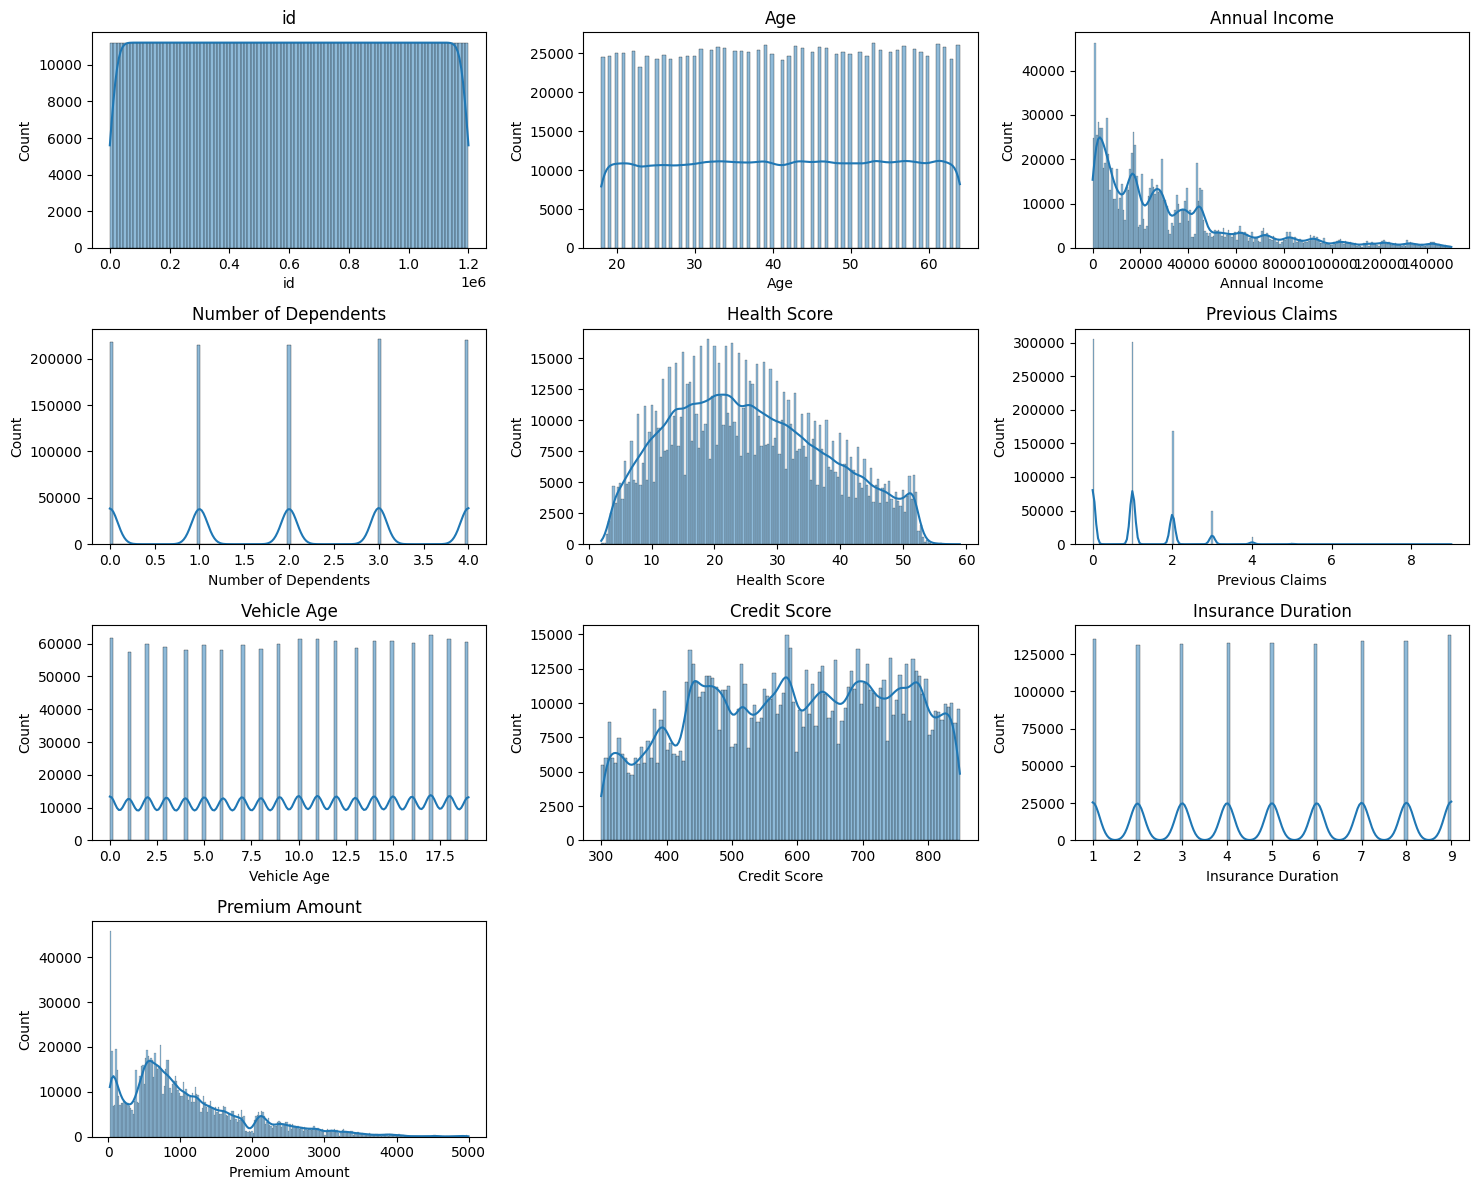

In [7]:
# Визуализация гистограмм
def plot_histograms(df):
    # Определить количество строк и столбцов для подграфиков
    n_cols = 3
    n_rows = (len(df.columns) + n_cols - 1) // n_cols
    
    # Создать фигуру с нужным размером
    plt.figure(figsize=(n_cols * 5, n_rows * 3))
    
    for i, column in enumerate(df.columns, start=1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[column], kde=True)
        
        # Добавить название столбца как заголовок графика
        plt.title(column)
        
    plt.tight_layout()
    plt.show()

# Применение функции к DataFrame df
plot_histograms(df[col_num])

In [8]:
col_cat = df.select_dtypes(include=["object"]).columns
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.000000,2,Male
Marital Status,0.015441,3,Single
Education Level,0.000000,4,Master's
Occupation,0.298396,3,Employed
Location,0.000000,3,Suburban
Policy Type,0.000000,3,Premium
Policy Start Date,0.000000,167381,2020-02-08 15:21:39.134960
Customer Feedback,0.064853,3,Average
Smoking Status,0.000000,2,Yes
Exercise Frequency,0.000000,4,Weekly


Данные столбца *Policy Start Date* - дата начала действия страхового полиса - будет сложно использовать при обучении модели регрессии, поэтому данный столбец удалим. По остальным столбцам видно, что имеются пропуски, будем исправлять.

In [9]:
df = df.drop(columns=["Policy Start Date"])

In [10]:
col_cat = df.select_dtypes(include=["object"]).columns
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.000000,2,Male
Marital Status,0.015441,3,Single
Education Level,0.000000,4,Master's
Occupation,0.298396,3,Employed
Location,0.000000,3,Suburban
Policy Type,0.000000,3,Premium
Customer Feedback,0.064853,3,Average
Smoking Status,0.000000,2,Yes
Exercise Frequency,0.000000,4,Weekly
Property Type,0.000000,3,House


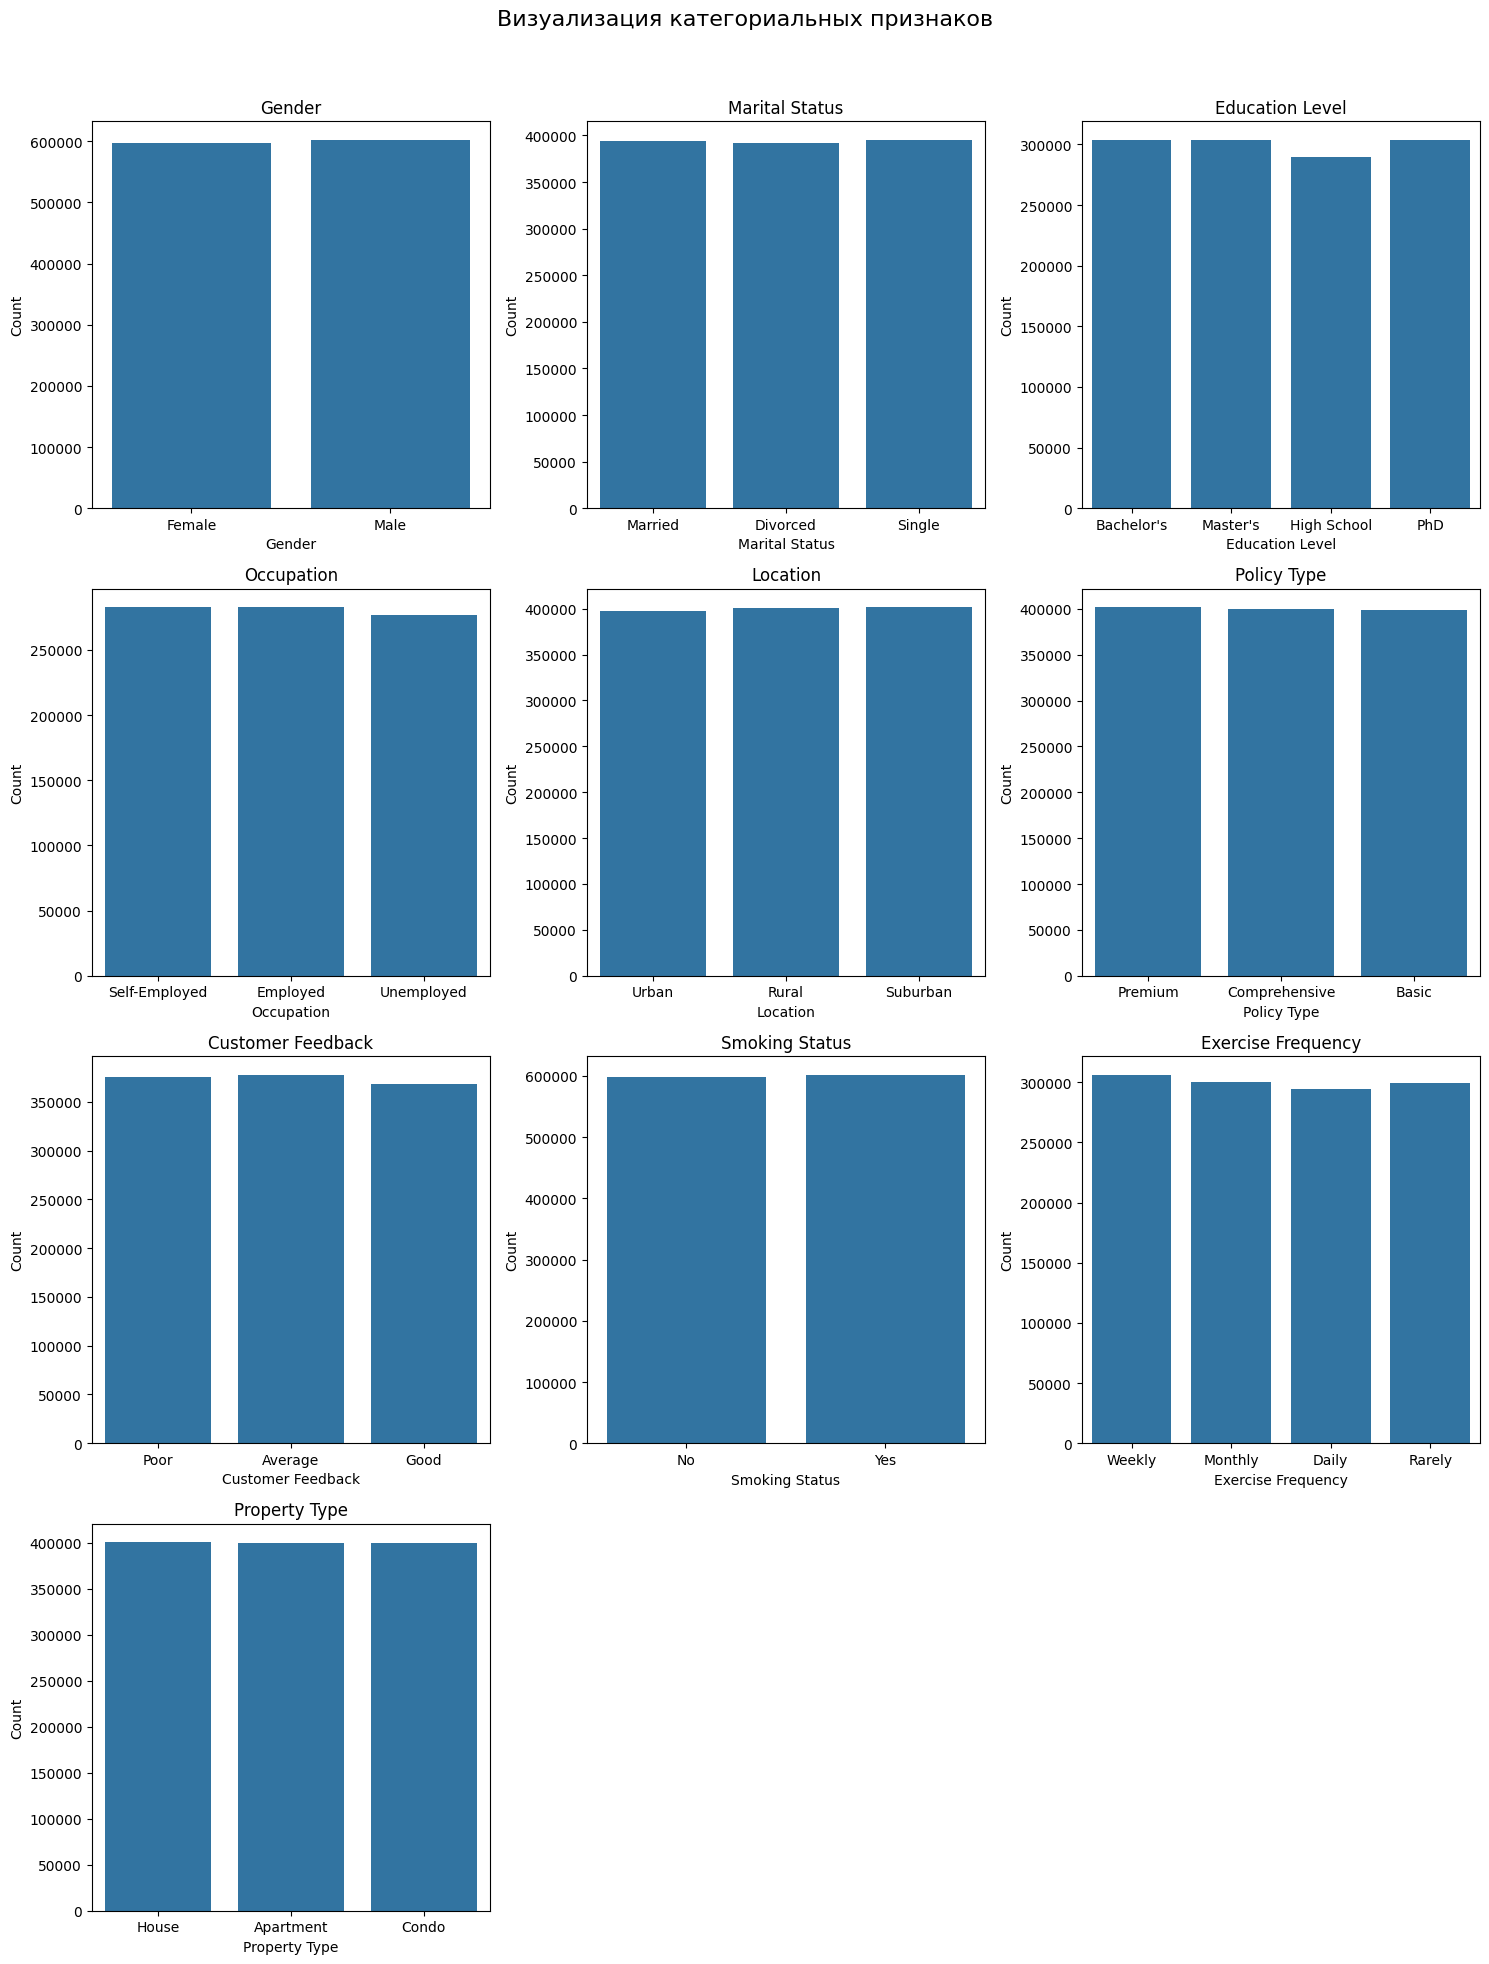

In [11]:
# Определение количества строк и столбцов для сетки
n = len(col_cat)
ncols = 3  # Количество столбцов в сетке
nrows = (n + ncols - 1) // ncols  # Количество строк

# Создание фигуры и подграфиков
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Преобразование в одномерный массив для удобства

# Создание столбчатой диаграммы для каждого категориального столбца
for i, column in enumerate(col_cat):
    sns.countplot(data=df, x=column, ax=axes[i])
    axes[i].set_title(column)  # Заголовок для каждого графика
    axes[i].set_xlabel(column)  # Подпись оси X
    axes[i].set_ylabel('Count')  # Подпись оси Y

# Удаление пустых подграфиков, если они есть
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Добавление заголовка к сетке графиков
fig.suptitle('Визуализация категориальных признаков', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Автоматическая настройка отступов
plt.show()  # Отображение графиков

## Подготовка датасета к построению моделей ML

### Целевая переменная

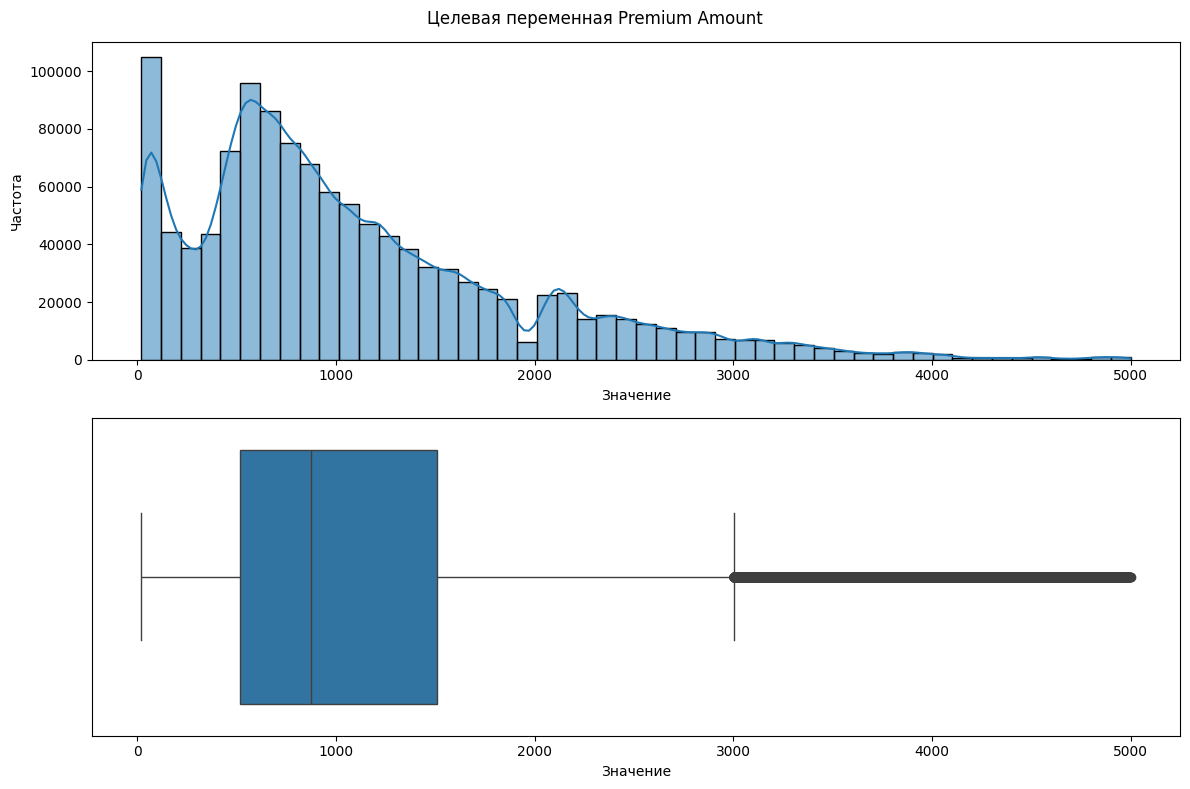

In [12]:
# Распределение целевой переменной
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.histplot(df['Premium Amount'], bins=50, kde=True, ax=ax[0])
ax[0].set_xlabel("Значение")
ax[0].set_ylabel("Частота")

sns.boxplot(df['Premium Amount'], orient="h", ax=ax[1])
ax[1].set_xlabel("Значение")
ax[1].set_yticks([])

plt.suptitle("Целевая переменная Premium Amount")
plt.tight_layout()
plt.show()

Видим, что имеются выбросы, но если их удалить, то потеряется достаточно много полезной информации. Оставим как есть.

### Обработка пропусков

In [13]:
print("Количество пропусков в числовых столбцах:")
print(df[col_num].isnull().sum())
print("\nКоличество пропусков в категориальных столбцах:")
print(df[col_cat].isnull().sum())

Количество пропусков в числовых столбцах:
id                           0
Age                      18705
Annual Income            44949
Number of Dependents    109672
Health Score             74076
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Premium Amount               0
dtype: int64

Количество пропусков в категориальных столбцах:
Gender                     0
Marital Status         18529
Education Level            0
Occupation            358075
Location                   0
Policy Type                0
Customer Feedback      77824
Smoking Status             0
Exercise Frequency         0
Property Type              0
dtype: int64


In [14]:
# Заполняем пропуски числовых переменных медианой
df[col_num] = df[col_num].fillna(df[col_num].median())

In [15]:
# Заполненяем пропуски модой для категориальных столбцов
for column in col_cat:
    mode_value = df[column].mode()[0]  # Получение моды
    df.fillna({column: mode_value}, inplace=True)  # Заполнение пропусков модой

In [16]:
print("Количество пропусков в числовых столбцах:")
print(df[col_num].isnull().sum())
print("\nКоличество пропусков в категориальных столбцах:")
print(df[col_cat].isnull().sum())

Количество пропусков в числовых столбцах:
id                      0
Age                     0
Annual Income           0
Number of Dependents    0
Health Score            0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Premium Amount          0
dtype: int64

Количество пропусков в категориальных столбцах:
Gender                0
Marital Status        0
Education Level       0
Occupation            0
Location              0
Policy Type           0
Customer Feedback     0
Smoking Status        0
Exercise Frequency    0
Property Type         0
dtype: int64


### Обработка выбросов

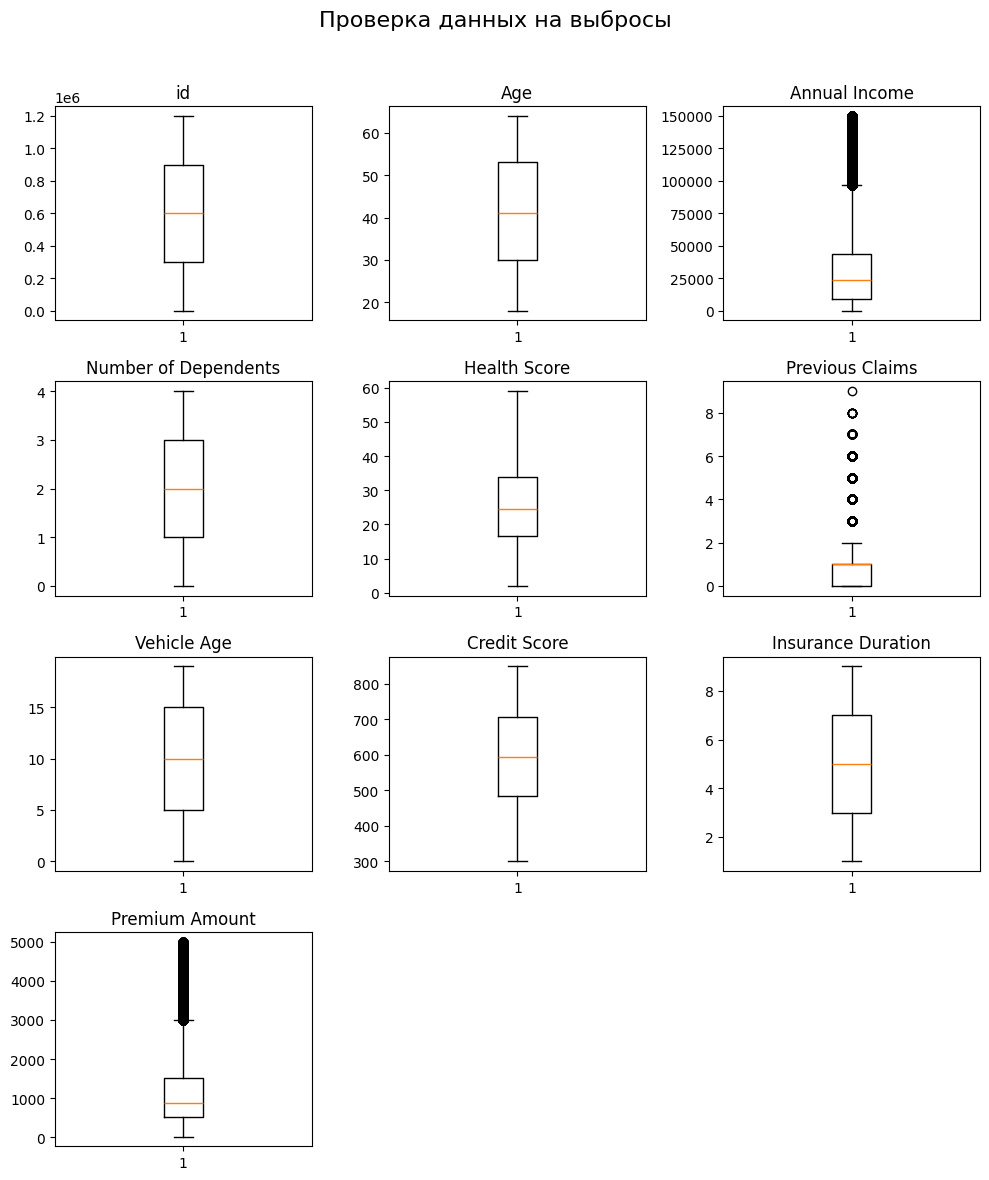

In [17]:
n = len(col_num)
ncols = 3  # Количество столбцов в сетке
nrows = (n + ncols - 1) // ncols  # Количество строк

# Создание фигуры и подграфиков
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3 * nrows))
axes = axes.flatten()  # Преобразование в одномерный массив для удобства

# Создание boxplot для каждого числового столбца
for i, column in enumerate(col_num):
    axes[i].boxplot(df[column])
    axes[i].set_title(column)  # Заголовок для каждого графика

# Удаление пустых подграфиков, если они есть
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
fig.suptitle("Проверка данных на выбросы", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Автоматическая настройка отступов
plt.show()  # Отображение графиков

In [18]:
df['Annual Income'].sort_values(ascending=False).head()

167855    149997.0
427875    149997.0
554201    149996.0
585837    149996.0
878127    149996.0
Name: Annual Income, dtype: float64

In [19]:
df['Annual Income'].sort_values().head()

1013454    1.0
539952     2.0
545990     2.0
571779     2.0
63472      2.0
Name: Annual Income, dtype: float64

In [20]:
df['Previous Claims'].sort_values().unique()

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

Большое количество выбросов видно в столбце *Annual Income*. Значения принимаются от 1 до 149997. Заменим выбросы с помощью помощью метода интерквантильного размаха. Столбец *Previus Claims* оставим без изменений, видим что там идет нормальное распределение значений.

In [21]:
# Обработаем выбросы
def outliers_in_data(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = df[col].quantile(0.1)
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    
    return df


df = outliers_in_data(df, ['Annual Income'])

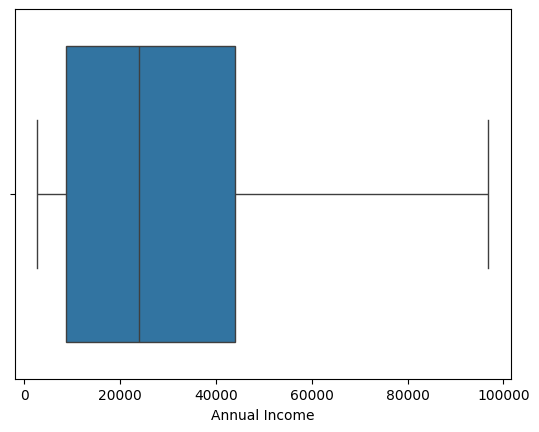

In [22]:
sns.boxplot(data=df, x='Annual Income')
plt.show()

In [23]:
df['Annual Income'].sort_values(ascending=False).head()

29        96871.0
3         96871.0
103382    96871.0
953379    96871.0
953371    96871.0
Name: Annual Income, dtype: float64

In [24]:
df['Annual Income'].sort_values().head()

8         2699.0
28        2699.0
799960    2699.0
799959    2699.0
799976    2699.0
Name: Annual Income, dtype: float64

## Проведем EDA после обработки данных

In [25]:
eda_num_info(df[col_num])

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
id,0.0,0.000000,1.199999e+06,599999.500000,599999.500000,1.200001e+11,119999.900000,1.079999e+06,299999.750000,899999.25000
Age,0.0,18.000000,6.400000e+01,41.143294,41.000000,1.804729e+02,22.000000,6.000000e+01,30.000000,53.00000
Annual Income,0.0,2699.000000,9.687100e+04,31122.853124,23911.000000,7.576032e+08,2699.000000,7.944810e+04,8646.000000,43936.00000
Number of Dependents,0.0,0.000000,4.000000e+00,2.009026,2.000000,1.825259e+00,0.000000,4.000000e+00,1.000000,3.00000
Health Score,0.0,2.012237,5.897591e+01,25.550001,24.578648,1.397934e+02,10.185439,4.284583e+01,16.554572,33.77289
Previous Claims,0.0,0.000000,9.000000e+00,1.001873,1.000000,6.729404e-01,0.000000,2.000000e+00,0.000000,1.00000
Vehicle Age,0.0,0.000000,1.900000e+01,9.569891,10.000000,3.336419e+01,2.000000,1.800000e+01,5.000000,15.00000
Credit Score,0.0,300.000000,8.490000e+02,593.162846,595.000000,1.991035e+04,393.000000,7.870000e+02,484.000000,706.00000
Insurance Duration,0.0,1.000000,9.000000e+00,5.018219,5.000000,6.730550e+00,1.000000,9.000000e+00,3.000000,7.00000
Premium Amount,0.0,20.000000,4.999000e+03,1102.544822,872.000000,7.482230e+05,150.000000,2.363000e+03,514.000000,1509.00000


In [26]:
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.0,2,Male
Marital Status,0.0,3,Single
Education Level,0.0,4,Master's
Occupation,0.0,3,Employed
Location,0.0,3,Suburban
Policy Type,0.0,3,Premium
Customer Feedback,0.0,3,Average
Smoking Status,0.0,2,Yes
Exercise Frequency,0.0,4,Weekly
Property Type,0.0,3,House


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1200000 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1200000 non-null  float64
 4   Marital Status        1200000 non-null  object 
 5   Number of Dependents  1200000 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            1200000 non-null  object 
 8   Health Score          1200000 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       1200000 non-null  float64
 12  Vehicle Age           1200000 non-null  float64
 13  Credit Score          1200000 non-null  float64
 14  Insurance Duration    1200000 non-

Пропуски и выбросы обработаны.

## Построим матрицу корреляций

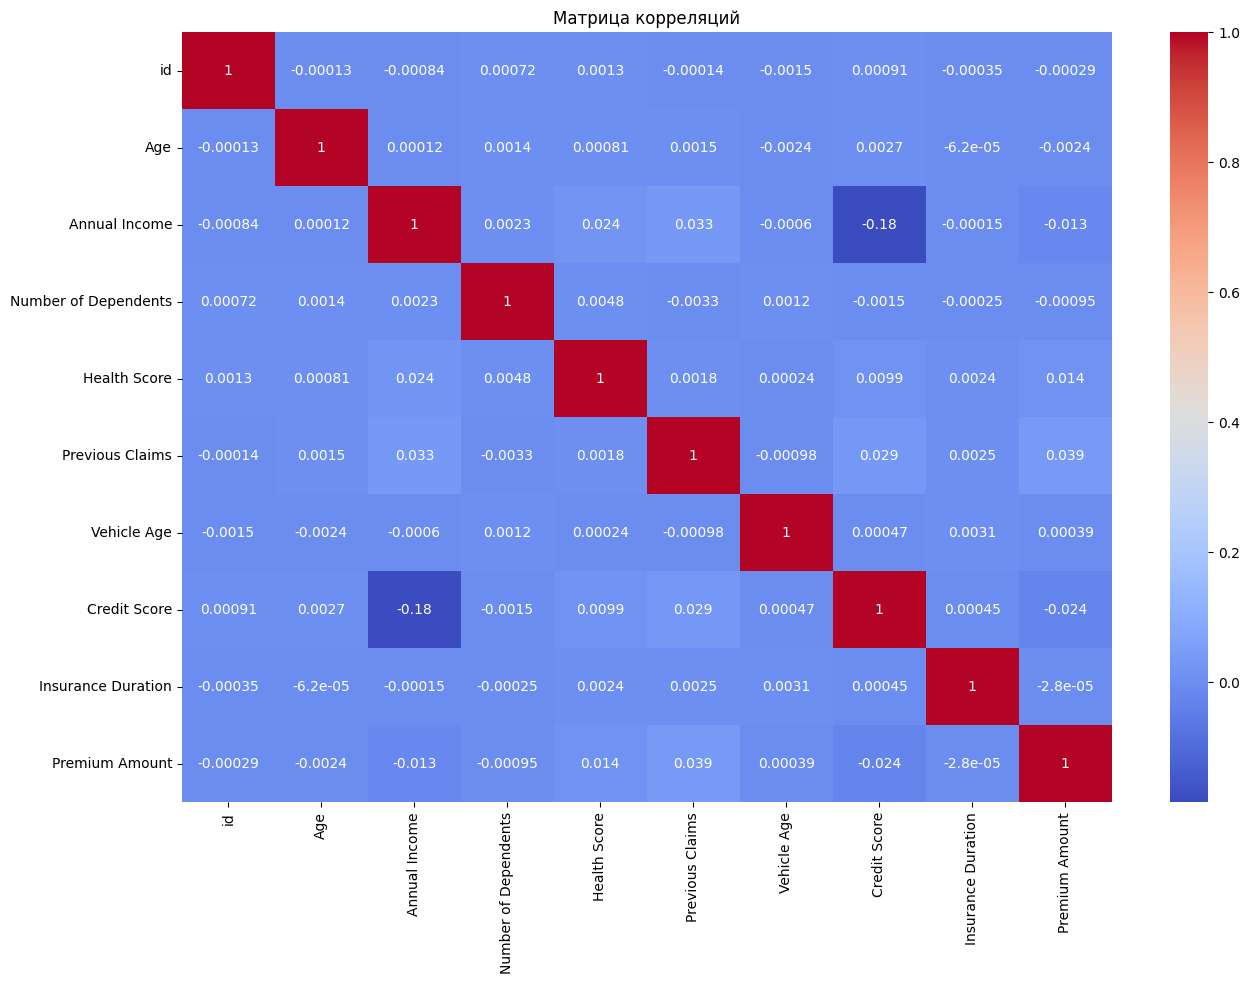

In [28]:
corr = df[col_num].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Матрица корреляций")
plt.show()

Явных корреляций не заметно.

## Уменьшаем исходный датасет

**Для удобства и скорости расчетов уменьшим исходный датафрейм в 10 раз:**

- `Квантильная группировка`: Используем *pd.qcut* для разделения целевой переменной на 10 квантильных групп.

- `Стратифицированная выборка`: Для каждой квантильной группы выбираем 10% данных, сохраняя пропорции.

Таким образом мы получаем уменьшенную копию нашего датасета.

In [29]:
df['Premium_Amount_quantile'] = pd.qcut(df['Premium Amount'], q=10, labels=False)

In [30]:
def stratified_sample(group):
    return group.sample(frac=0.1, random_state=42)

In [31]:
df_short = df.groupby('Premium_Amount_quantile').apply(stratified_sample).reset_index(drop=True)

# Выводим информацию о новом датасете
print("Исходный размер датасета:", df.shape)
print("Размер уменьшенного датасета:", df_short.shape)
print("Распределение целевой переменной в начальном датасете:")
print(df['Premium Amount'].describe())
print("Распределение целевой переменной в уменьшенном датасете:")
print(df_short['Premium Amount'].describe())

Исходный размер датасета: (1200000, 21)
Размер уменьшенного датасета: (120000, 21)
Распределение целевой переменной в начальном датасете:
count    1.200000e+06
mean     1.102545e+03
std      8.649989e+02
min      2.000000e+01
25%      5.140000e+02
50%      8.720000e+02
75%      1.509000e+03
max      4.999000e+03
Name: Premium Amount, dtype: float64
Распределение целевой переменной в уменьшенном датасете:
count    120000.000000
mean       1102.362292
std         864.908820
min          20.000000
25%         514.000000
50%         872.000000
75%        1507.000000
max        4988.000000
Name: Premium Amount, dtype: float64


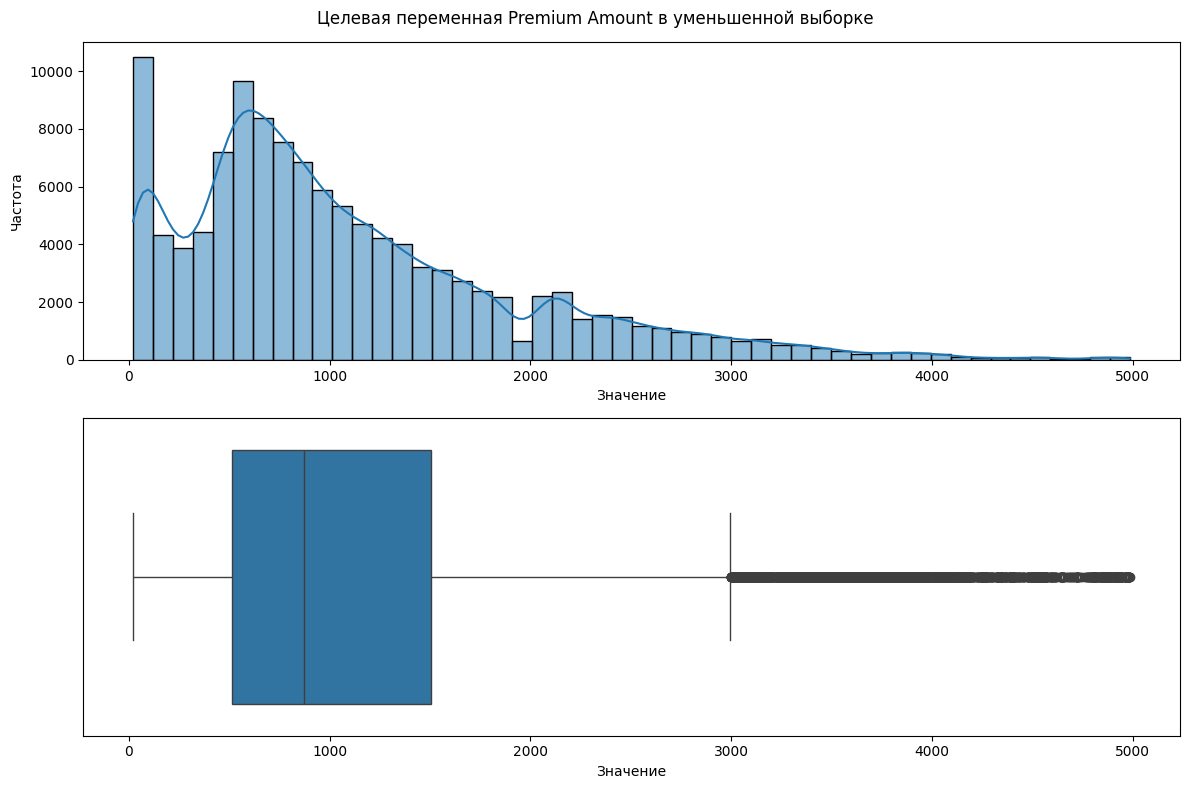

In [32]:
# Распределение целевой переменной
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.histplot(df_short['Premium Amount'], bins=50, kde=True, ax=ax[0])
ax[0].set_xlabel("Значение")
ax[0].set_ylabel("Частота")

sns.boxplot(df_short['Premium Amount'], orient="h", ax=ax[1])
ax[1].set_xlabel("Значение")
ax[1].set_yticks([])

plt.suptitle("Целевая переменная Premium Amount в уменьшенной выборке")
plt.tight_layout()
plt.show()

Графики распределения целевой переменной для полной и уменьшенной выборок идентичные.

## Кодирование категориальных столбцов

In [33]:
# Используем метод OneHotEncoding
df_short = pd.get_dummies(df_short, columns=col_cat, drop_first=True, dtype=int)

df_short.head()

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,9924,18.0,8773.0,3.0,36.352452,2.0,10.0,595.0,1.0,104.0,...,0,0,1,0,0,1,0,0,0,0
1,448793,47.0,23911.0,4.0,42.947791,2.0,4.0,784.0,5.0,25.0,...,0,1,0,0,1,0,0,1,0,1
2,259981,58.0,52848.0,2.0,20.099202,1.0,12.0,591.0,5.0,135.0,...,0,0,0,1,0,0,0,1,0,1
3,639001,47.0,6006.0,4.0,15.173677,2.0,19.0,595.0,3.0,22.0,...,0,1,1,0,0,0,0,0,0,1
4,138394,64.0,54786.0,0.0,11.958989,2.0,3.0,656.0,1.0,144.0,...,0,0,0,0,0,0,0,0,1,0


## Разделим на тренировочную и тестовую выборки

In [34]:
X = df_short.drop(columns=['id', 'Premium Amount', 'Premium_Amount_quantile'])
y = df_short['Premium Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Размер тренировочной выборки (признаки):', X_train.shape)
print('Размер тестовой выборки (признаки):', X_test.shape)
print('Размер тренировочной выборки (целевой признак):', y_train.shape)
print('Размер тестовой выборки (целевой признак):', y_test.shape)

Размер тренировочной выборки (признаки): (96000, 28)
Размер тестовой выборки (признаки): (24000, 28)
Размер тренировочной выборки (целевой признак): (96000,)
Размер тестовой выборки (целевой признак): (24000,)


In [35]:
# Отшкалируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
pd.DataFrame(X_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.694798,-0.914625,-0.749113,0.139481,0.002034,-1.315567,0.848276,-1.547260,-1.006333,1.436479,...,-0.703993,-0.712699,-0.667719,1.480117,0.997295,-0.578665,-0.57618,-0.584616,-0.706908,-0.709445
1,0.655388,-1.032236,-0.008989,-0.586443,1.222669,-1.315567,0.635961,-1.547260,0.993707,-0.696147,...,1.420468,-0.712699,1.497636,-0.675622,-1.002712,1.728115,-0.57618,-0.584616,1.414611,-0.709445
2,0.358413,-1.032236,-0.008989,-1.015573,1.222669,1.636673,-1.069641,-1.547260,-1.006333,-0.696147,...,1.420468,-0.712699,-0.667719,1.480117,-1.002712,-0.578665,1.73557,-0.584616,-0.706908,-0.709445
3,-1.720407,-1.017275,-0.749113,-0.121960,-1.218600,0.421045,-1.791513,0.763065,-1.006333,-0.696147,...,1.420468,-0.712699,-0.667719,-0.675622,0.997295,-0.578665,-0.57618,1.710526,-0.706908,-0.709445
4,0.209926,0.158985,0.731134,1.554456,0.002034,-1.489228,1.570149,-0.007043,-1.006333,-0.696147,...,-0.703993,1.403116,-0.667719,1.480117,0.997295,-0.578665,1.73557,-0.584616,1.414611,-0.709445


## Обучим модели (без подбора гиперпараметров)

In [37]:
# Обучение моделей
lr_model = LinearRegression()
ridge_model = Ridge()
lasso_model = Lasso()
elastic_net_model = ElasticNet()
dt_model = DecisionTreeRegressor()

lr_model.fit(X_train_scaled, y_train)
ridge_model.fit(X_train_scaled, y_train)
lasso_model.fit(X_train_scaled, y_train)
elastic_net_model.fit(X_train_scaled, y_train)
dt_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test_scaled)
ridge_pred = ridge_model.predict(X_test_scaled)
lasso_pred = lasso_model.predict(X_test_scaled)
elastic_net_pred = elastic_net_model.predict(X_test_scaled)
dt_pred = dt_model.predict(X_test)

Oценим качество каждой модели с помощью метрик **MSE, RMSE, R2 и MAE**.

In [38]:

# Оценка качества
models = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'DecisionTreeRegressor']
mse = [
    mean_squared_error(y_test, lr_pred),
    mean_squared_error(y_test, ridge_pred),
    mean_squared_error(y_test, lasso_pred),
    mean_squared_error(y_test, elastic_net_pred),
    mean_squared_error(y_test, dt_pred)
]

rmse = [
    root_mean_squared_error(y_test, lr_pred),
    root_mean_squared_error(y_test, ridge_pred),
    root_mean_squared_error(y_test, lasso_pred),
    root_mean_squared_error(y_test, elastic_net_pred),
    root_mean_squared_error(y_test, dt_pred)
]

r2 = [
    r2_score(y_test, lr_pred),
    r2_score(y_test, ridge_pred),
    r2_score(y_test, lasso_pred),
    r2_score(y_test, elastic_net_pred),
    r2_score(y_test, dt_pred)
]

mae = [
    mean_absolute_error(y_test, lr_pred),
    mean_absolute_error(y_test, ridge_pred),
    mean_absolute_error(y_test, lasso_pred),
    mean_absolute_error(y_test, elastic_net_pred),
    mean_absolute_error(y_test, dt_pred)
]

# Вывод результатов
results_1 = pd.DataFrame({
    'Model': models,
    'RMSE': rmse,
    'MSE': mse,
    'R2': r2,
    'MAE' : mae
})

print(results_1)

                   Model         RMSE           MSE        R2         MAE
0       LinearRegression   858.243983  7.365827e+05  0.001870  666.303736
1                  Ridge   858.243978  7.365827e+05  0.001870  666.303738
2                  Lasso   858.167894  7.364521e+05  0.002047  666.284047
3             ElasticNet   858.277059  7.366395e+05  0.001793  666.473997
4  DecisionTreeRegressor  1242.061586  1.542717e+06 -1.090509  906.427167


## Регрессия Decision Tree (c подбором гиперпараметров)

Подберем гиперпараметры для модели с помощью **GridSearchCV** и проверим как изменятся метрики качества.

In [39]:
# Определяем сетку гиперпараметров
param_grid = {
    # 'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [None] + [i for i in range(1, 10, 2)],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'ccp_alpha': [0.01, 0.02, 0.03]
}

# Создаем модель решающего дерева
dt_model_hyper = DecisionTreeRegressor()

# Создаем объект GridSearchCV c сеткой параметров
grid_search = GridSearchCV(dt_model_hyper, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(X_train, y_train)

print('Лучшее значение параметра:', grid_search.best_params_)

# Создаем модель решающего дерева
best_dt_model = grid_search.best_estimator_

Лучшее значение параметра: {'ccp_alpha': 0.03, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 8}


In [40]:
dt_pred_best = best_dt_model.predict(X_test)

In [41]:
# Оценка качества
models = ['DecisionTreeRegressor (no hyperparameters)', 'DecisionTreeRegressor (with hyperparameters)']
mse = [
    mean_squared_error(y_test, dt_pred),
    mean_squared_error(y_test, dt_pred_best)
]

rmse = [
    root_mean_squared_error(y_test, dt_pred),
    root_mean_squared_error(y_test, dt_pred_best)
]

r2 = [
    r2_score(y_test, dt_pred),
    r2_score(y_test, dt_pred_best)
]

mae = [
    mean_absolute_error(y_test, dt_pred),
    mean_absolute_error(y_test, dt_pred_best)
]

# Вывод результатов
results_2 = pd.DataFrame({
    'Model': models,
    'RMSE': rmse,
    'MSE': mse,
    'R2': r2,
    'MAE' : mae
})

print(results_2)

                                          Model         RMSE           MSE  \
0    DecisionTreeRegressor (no hyperparameters)  1242.061586  1.542717e+06   
1  DecisionTreeRegressor (with hyperparameters)   848.755798  7.203864e+05   

         R2         MAE  
0 -1.090509  906.427167  
1  0.023817  648.053207  


Видим, что подбор гиперпараметров значительно улучшил значения метрик качества, они стали даже лучше, чем у линейных моделей.

## Визуализация дерева решений

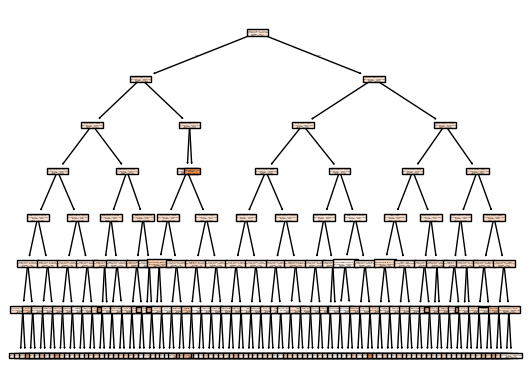

In [45]:
plot_tree(best_dt_model, feature_names=X.columns, filled=True)
plt.show()

root_mean_squared_error: 850.16


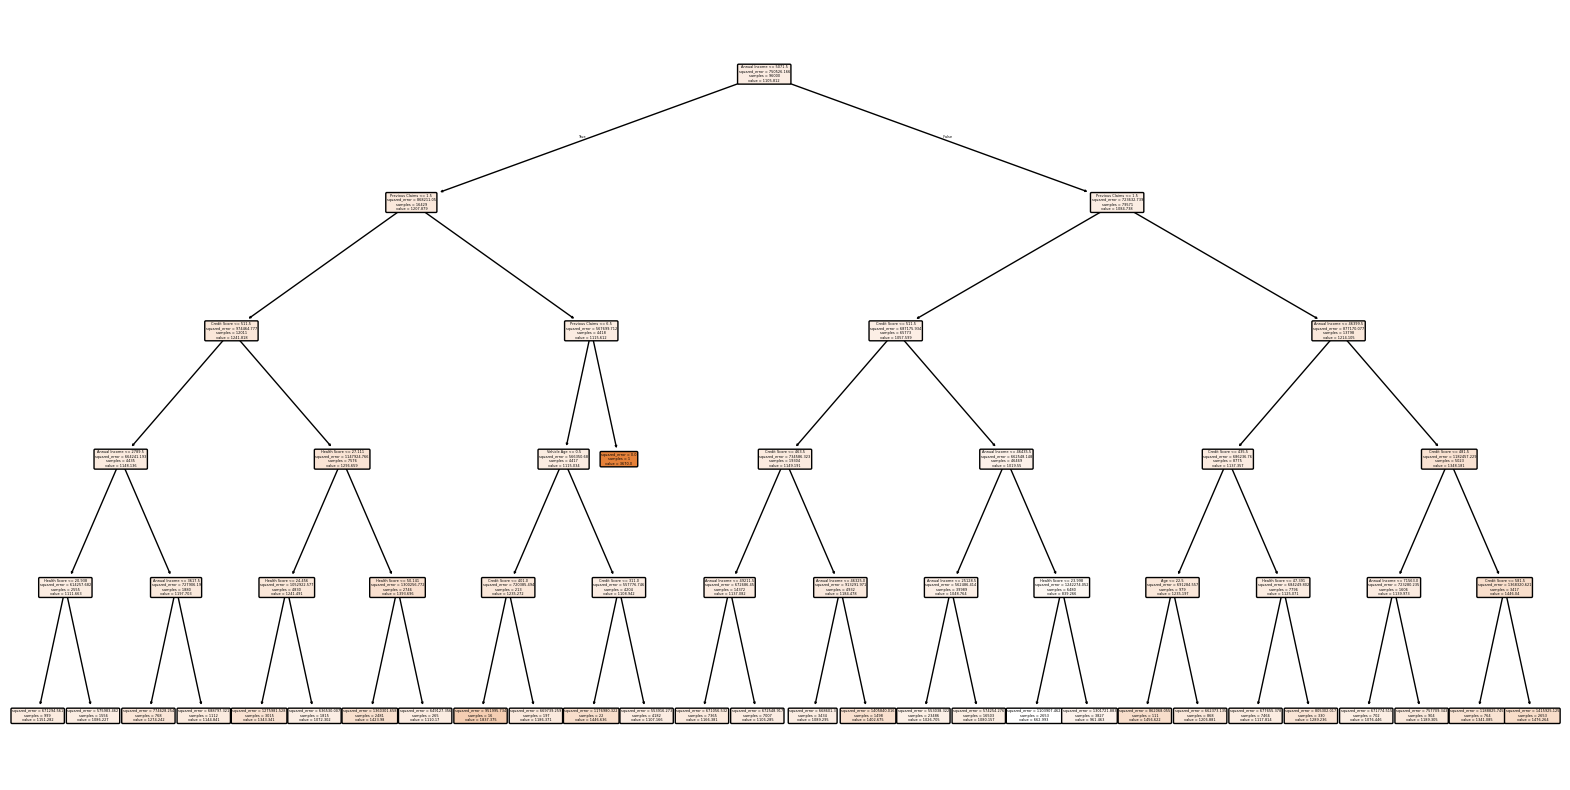

In [ ]:
# Глубина дерева 5
dt_max_depth_5 = DecisionTreeRegressor(
    max_depth=5,
    ccp_alpha=0.03, 
    min_samples_leaf=1, 
    min_samples_split=8
  )
dt_max_depth_5.fit(X_train, y_train)
print(
    f"root_mean_squared_error: {root_mean_squared_error(y_test, dt_max_depth_5.predict(X_test)):.2f}"
)

# Отрисовка дерева
plt.figure(figsize=(20, 10))  # Установка размера графика
plot_tree(
    dt_max_depth_5,
    feature_names=X.columns,
    filled=True,  # Заполнение узлов цветом в зависимости от класса
    rounded=True  # Закругленные углы у прямоугольников узлов
)

# Сохранение графика в файл
plt.savefig('tree_plot_max_depth_5.png', bbox_inches='tight')

plt.show()

root_mean_squared_error: 854.70


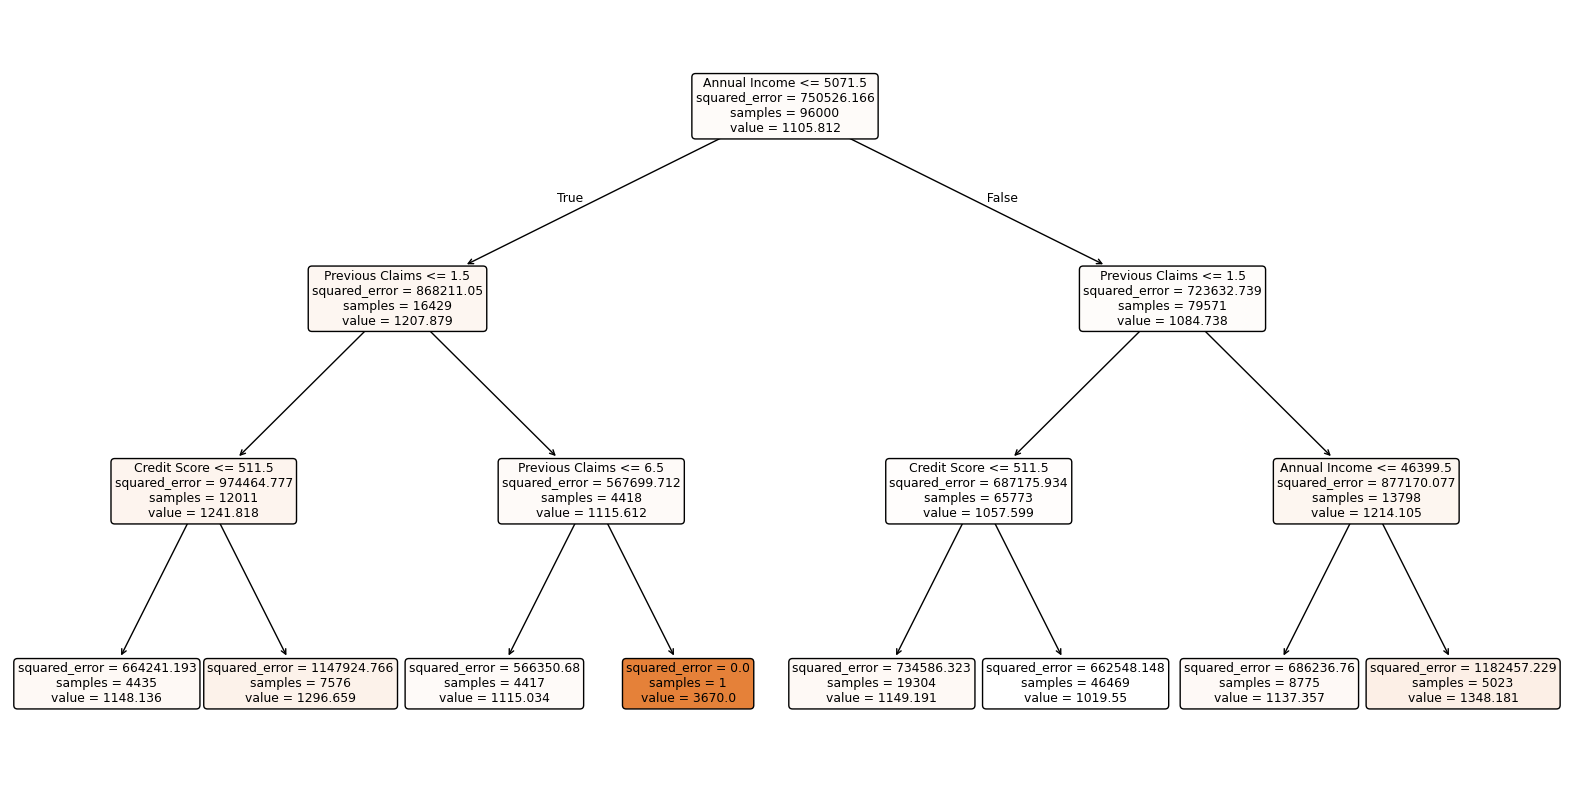

In [ ]:
# Глубина дерева 3
dt_max_depth_3 = DecisionTreeRegressor(
    max_depth=3,
    ccp_alpha=0.03, 
    min_samples_leaf=1, 
    min_samples_split=8
  )
dt_max_depth_3.fit(X_train, y_train)
print(
    f"root_mean_squared_error: {root_mean_squared_error(y_test, dt_max_depth_3.predict(X_test)):.2f}"
)

# Отрисовка дерева
plt.figure(figsize=(20, 10))  # Установка размера графика
plot_tree(
    dt_max_depth_3,
    feature_names=X.columns,
    filled=True,  # Заполнение узлов цветом в зависимости от класса
    rounded=True  # Закругленные углы у прямоугольников узлов
)

# Сохранение графика в файл
plt.savefig('tree_plot_max_depth_3.png', bbox_inches='tight')

plt.show()

## Дерево решений (текстовый вариант)

In [49]:
text_representation = export_text(best_dt_model, feature_names=X.columns)
print(text_representation)

|--- Annual Income <= 5071.50
|   |--- Previous Claims <= 1.50
|   |   |--- Credit Score <= 511.50
|   |   |   |--- Annual Income <= 2789.50
|   |   |   |   |--- Health Score <= 20.94
|   |   |   |   |   |--- Health Score <= 20.87
|   |   |   |   |   |   |--- Occupation_Self-Employed <= 0.50
|   |   |   |   |   |   |   |--- value: [1180.81]
|   |   |   |   |   |   |--- Occupation_Self-Employed >  0.50
|   |   |   |   |   |   |   |--- value: [1027.96]
|   |   |   |   |   |--- Health Score >  20.87
|   |   |   |   |   |   |--- Credit Score <= 478.50
|   |   |   |   |   |   |   |--- value: [1431.17]
|   |   |   |   |   |   |--- Credit Score >  478.50
|   |   |   |   |   |   |   |--- value: [3176.33]
|   |   |   |   |--- Health Score >  20.94
|   |   |   |   |   |--- Health Score <= 37.03
|   |   |   |   |   |   |--- Occupation_Unemployed <= 0.50
|   |   |   |   |   |   |   |--- value: [1086.74]
|   |   |   |   |   |   |--- Occupation_Unemployed >  0.50
|   |   |   |   |   |   |   |--- val

## Важность признаков

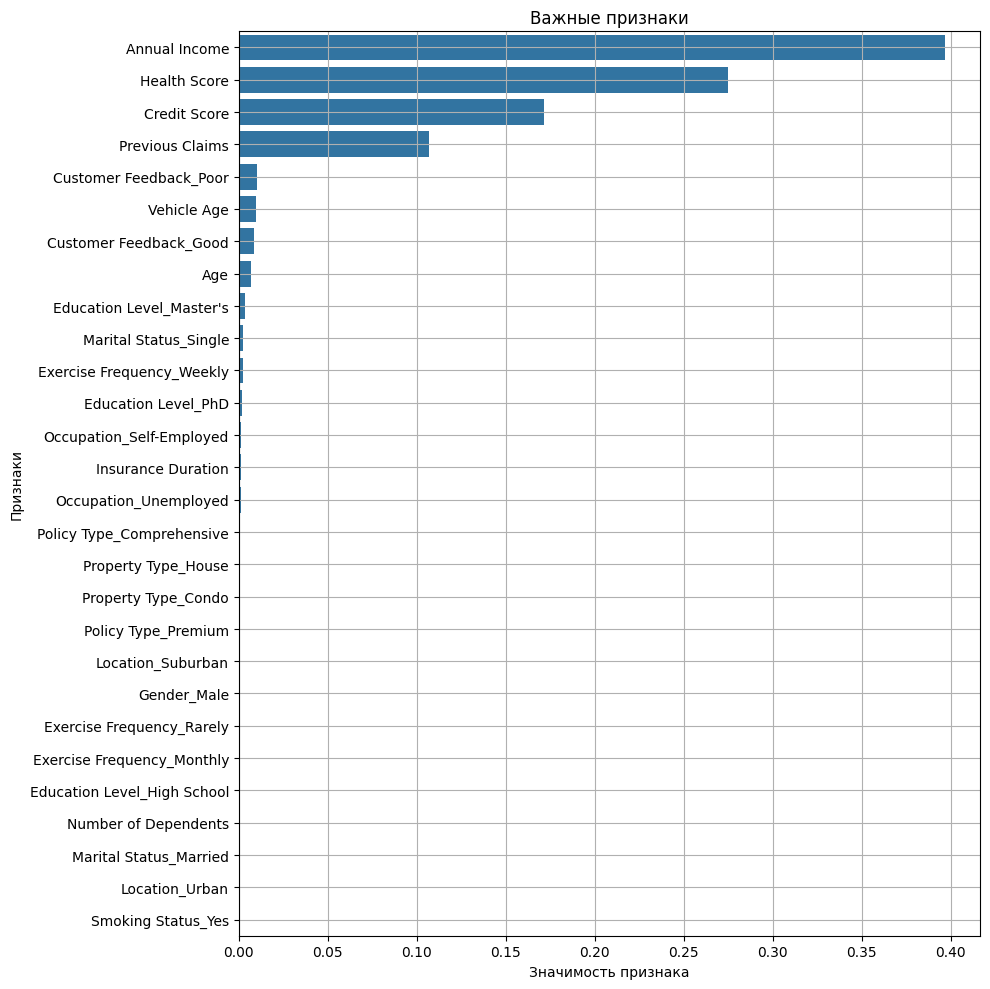

In [50]:
feature_imp_1 = pd.DataFrame(
    sorted(zip(best_dt_model.feature_importances_, X.columns)),
    columns=['Значимость признака','Признаки'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Значимость признака",
            y="Признаки",
            data=feature_imp_1.sort_values(
                by="Значимость признака",
                ascending=False)
            )
plt.title('Важные признаки')
plt.tight_layout()
plt.grid()
plt.show()

Наиболее важными признаками при построении Дерева решений являются: `Annual Income, Health Score, Credit Score, Previous Claim`.